<a href="https://colab.research.google.com/github/namirinz/YSC21-AI_KME/blob/master/Image_Captioning/KME_Image_captioning_bahdanau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
!pip install nami -U -q
!rm -rf .keras

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 952kB 16.9MB/s 
     |████████████████████████████████| 36.7MB 151kB/s 
albumentations==0.5.2 is successfully installed


In [ ]:
import nami
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import albumentations as A

8192/667 [================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-aac39ad0-6575-8679-1258-778a479f152e)


# Import Dataset

In [ ]:
from nami.datasets.kme import load_data
(image_train, caption_train), (image_test, caption_test) = load_data(test_size = 0.3)
print(image_train.shape, caption_train.shape)
print(image_test.shape, caption_test.shape)

254615552/254610128 [==============================] - 7s 0us/step
(660, 300, 300, 3) (660,)
(283, 300, 300, 3) (283,)


## Preprocessing Dataset

In [ ]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(caption_train)

In [ ]:
text2seq_train = tokenizer.text_to_sequences(caption_train)
seq2text_train = tokenizer.sequences_to_text(text2seq_train)

In [ ]:
text2seq_test = tokenizer.text_to_sequences(caption_test)
seq2text_test = tokenizer.sequences_to_text(text2seq_test)

## Hyperparameter

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
units = 512
vocab_size = len(tokenizer.word2index)

IMG_SIZE = 300
IMG_SHAPE = (300, 300, 3)

num_steps_train = len(image_train) // BATCH_SIZE
num_steps_test = len(image_test) // BATCH_SIZE

max_length_train = text2seq_train.shape[1]
max_length_test = text2seq_test.shape[1]

encoding_size = 512 # Determines dimension of the encodings of images
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create Dataset

## Augmentation

In [ ]:
transforms = A.Compose([
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=[-0.2, 0.2], rotate_limit=45, p=0.9, border_mode=1),
            A.GaussNoise(var_limit=(0, 225), p= 0.9), A.Blur(blur_limit= 3, p= 0.5),
            #HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.Flip(p= 0.5), A.Transpose(p= 0.5),
            A.ToGray(p= 0.7), A.ChannelShuffle(p= 0.5), A.RandomBrightness(limit=(-0.10, 0.0), p= 0.5)
            

        ])

In [ ]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [ ]:
def process_data(image, label, img_size=IMG_SIZE):
  aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
  return aug_img, label

In [ ]:
def set_shapes(img, label, img_shape=IMG_SHAPE):
    img.set_shape(img_shape)
    #label.set_shape([])
    return img, label

## Tf.data.Dataset

In [ ]:
from functools import partial

dataset = tf.data.Dataset.from_tensor_slices((image_train, text2seq_train))
print(dataset)
dataset = dataset.map(partial(process_data, img_size=IMG_SIZE),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
print(dataset)
dataset = dataset.map(set_shapes, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
print(dataset)

<TensorSliceDataset shapes: ((300, 300, 3), (58,)), types: (tf.uint8, tf.int32)>
<PrefetchDataset shapes: (<unknown>, (58,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 300, 300, 3), (None, 58)), types: (tf.float32, tf.int32)>


In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((image_test, text2seq_test)).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
dataset_val

<PrefetchDataset shapes: ((None, 300, 300, 3), (None, 28)), types: (tf.uint8, tf.int32)>

## Plot Augmentation

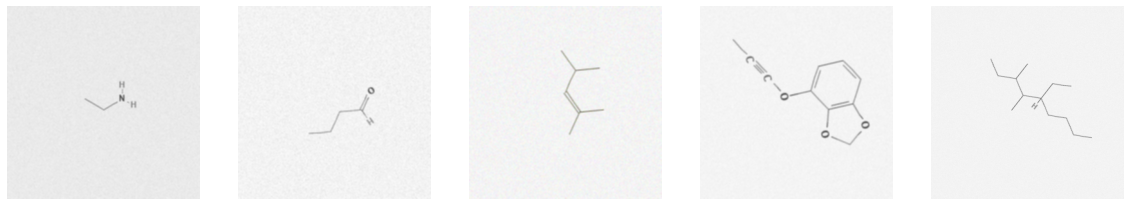

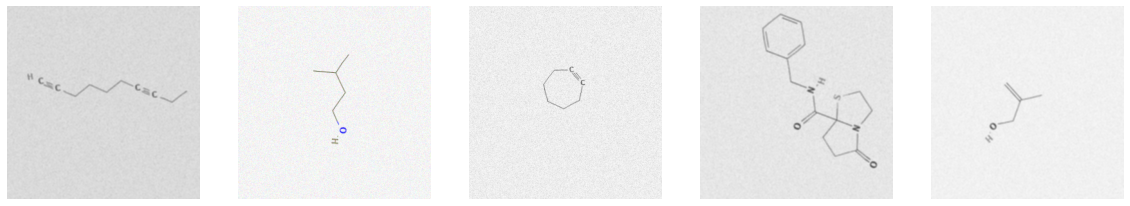

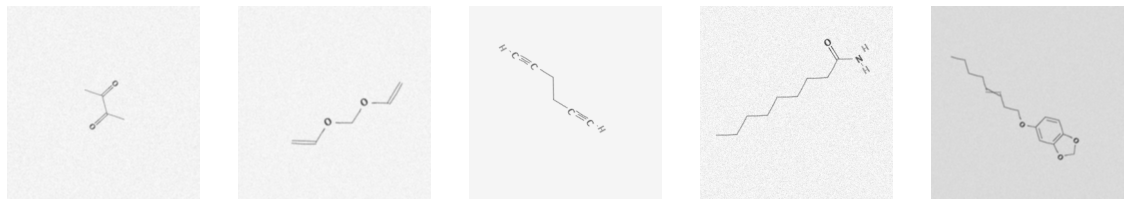

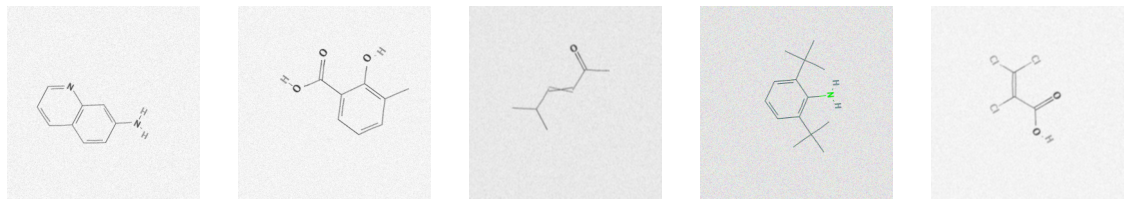

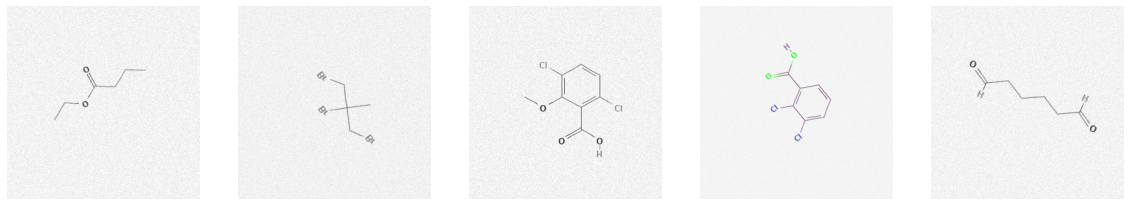

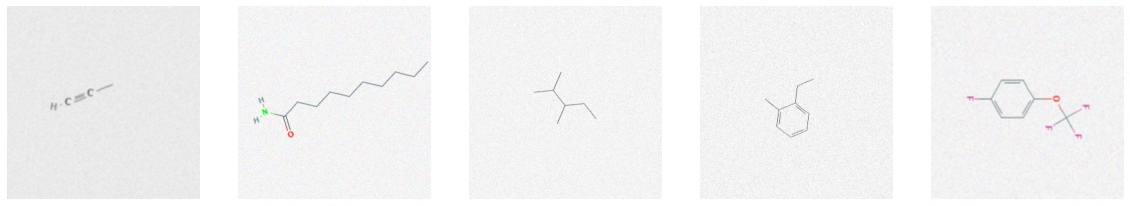

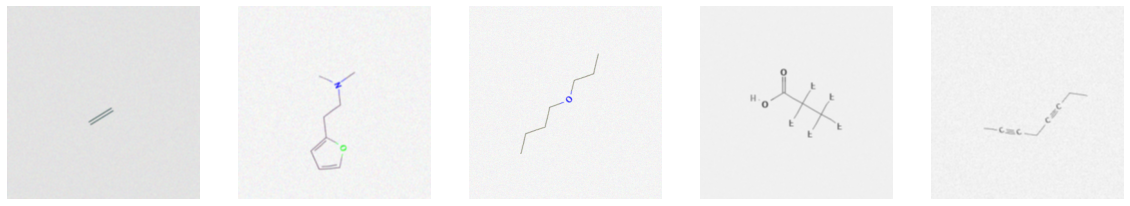

In [ ]:
# Test parameter of ImageDataGenerator
for index, (img, label) in enumerate(dataset):
  plt.figure(figsize=(20, 20))
  for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow( tf.cast(img[i], tf.uint8) )
    plt.axis('off')
  plt.show()
  if index == 6:
    break

# Model Architecture

## EfficientNet-B7


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pret_model = EfficientNetB7(include_top = False, weights='imagenet', input_shape=IMG_SHAPE)

pret_model.trainable = False

attention_features_shape = 10 * 10
features_shape = 1536

# Xception : [7, 7, 2048]
# InceptionResNetV2 : [5, 5, 1536]
# EfficientNetB0 : [7, 7, 2560]

258080768/258076736 [==============================] - 10s 0us/step


In [ ]:
pret_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

## CNN Encoder (Encoder output of feature extraction)

In [ ]:
from tensorflow.keras.models import Sequential

def create_encoder():
  x = tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer")(pret_model.output)
  output = tf.keras.layers.Reshape(target_shape=(attention_features_shape, encoding_size))(x)
  return tf.keras.Model(pret_model.input, output)

In [ ]:
encoder = create_encoder()

In [ ]:
from tensorflow.keras.layers import BatchNormalization

for index, layer in enumerate(encoder.layers):
  if index <= 20 and not isinstance(layer, BatchNormalization):
    layer.trainable = True

In [ ]:
encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

## Bahdanau Attention

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GRU

In [ ]:
def create_attention(features, hidden):
  # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)
  # hidden shape == (batch_size, hidden_size)
  
  # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
  hidden_with_time_axis = tf.expand_dims(hidden, 1)

  # attention_hidden_layer shape == (batch_size, 25, units)
  attention_hidden_layer = tf.nn.tanh( Dense(units)(features) + Dense(units)(hidden_with_time_axis) )
  
  # score shape == (batch_size, 25, 1)
  # This gives you an unnormalized score for each image feature.
  score = tf.keras.layers.Dense(1)(attention_hidden_layer)

    # attention_weights shape == (batch_size, 25, 1)
  attention_weights = tf.nn.softmax(score, axis=1)
  # attention_weights = tf.cast(attention_weights, dtype='float32')

  # context_vector shape after sum == (batch_size, hidden_size)
  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)

  return context_vector, attention_weights

## Create RNN Decoder

In [ ]:
def create_decoder():
  features = tf.keras.layers.Input((attention_features_shape, encoding_size))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))

  context_vector, attention_weights = create_attention(features, hidden)
  
  # x shape after passing through embedding == (batch_size, 1, encoding_size) 
  x = Embedding(vocab_size, encoding_size)(dec_input)
  
  # x shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)

  _, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(x, initial_state=[hidden])
  
  # shape == (batch_size, hidden_size)
  x = Dense(units, activation='tanh')(state)

  output = Dense(vocab_size, activation = 'softmax')(x)

  return tf.keras.models.Model([features, dec_input, hidden], [output, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

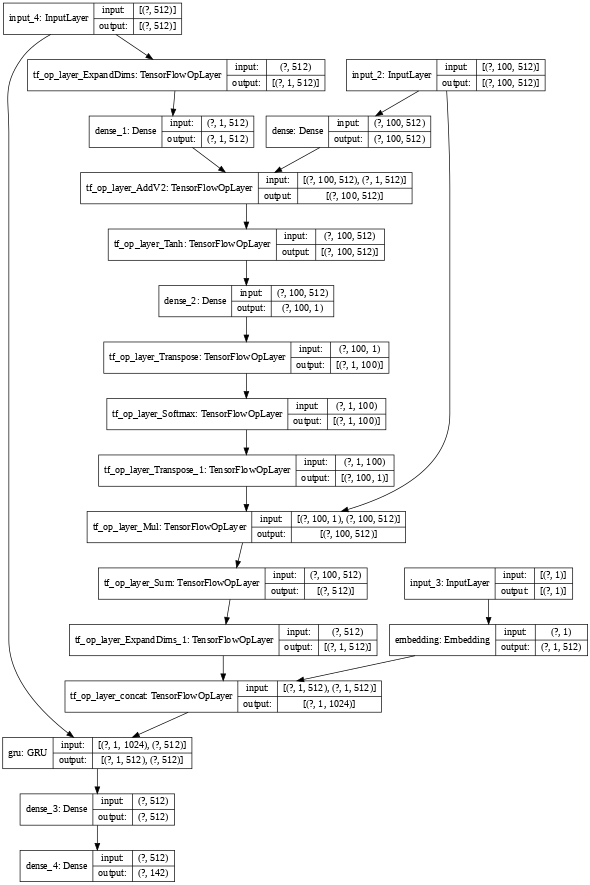

In [ ]:
decoder = create_decoder()
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi = 49)

# Custom Loss Function


In [ ]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word2index['<pad>'])) # make padding element -> true(1) -> false (0)
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # EOS Loss
  loss_object2 = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2)

  end_token = tokenizer.word2index['<end>']
  pred_id = tf.math.argmax(pred, axis=-1)

  real_eos = tf.cast(tf.math.equal(real, end_token), dtype=tf.float32)
  pred_eos = tf.cast(tf.math.equal(pred_id, end_token), dtype=tf.float32)

  loss_2 = loss_object2(real_eos, pred_eos)

  return tf.reduce_mean(loss_) + loss_2 

# Metrics

# Accuracy

In [ ]:
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Bleu

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class Bleu(tf.keras.metrics.Metric):
  def __init__(self, name='bleu', **kwargs):
    super(Bleu, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='score', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')
    self.chencherry = SmoothingFunction()

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = y_true[y_true != tokenizer.word2index['<pad>']]
    idx = np.where(y_pred == tokenizer.word2index['<end>'])[0]

    if idx != []:
      y_pred = y_pred[:idx[0]+1]
          
    values = sentence_bleu([y_true], y_pred, smoothing_function=self.chencherry.method4)

    self.count.assign_add(1)
    self.score.assign_add(values)

  def result(self):
    return self.score / self.count

  def reset_states(self):
    self.count.assign(0)
    self.score.assign(0)

# Callbacks

In [ ]:
class EarlyStopping():
  def __init__(self, monitor = 'val_bleu', mode = 'max', patience = 1, encoder = encoder, decoder = decoder):
    if mode == 'max':
      self.mode = 'max'
      self.best = -100
    else: # Min
      self.min = 'min'
      self.best = 100
    self.patience = patience
    self.wait = 0
    self.encoder = encoder
    self.decoder = decoder

  def callback(self, log, epoch):
    if self.mode == 'max':
      if log < self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} < best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save(f'Encoder_model{epoch}.h5', include_optimizer=False)
        self.decoder.save(f'Decoder_model{epoch}.h5', include_optimizer=False)
        print('Save Model Succesful')
    else:
      if log > self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} > best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save(f'Encoder_model{epoch}.h5', include_optimizer=False)
        self.decoder.save(f'Decoder_model{epoch}.h5', include_optimizer=False)
        print('Save Model Succesful')
    
    return False
  

In [ ]:
earlystop = EarlyStopping(patience = 7)

# Training Model

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001, decay_steps = 10000, decay_rate=0.96, staircase=True, name=None
)
opt = tf.keras.optimizers.Adam(lr_schedule)

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
bleu = Bleu()
bleu_val = Bleu()

## Train Step

In [ ]:
@tf.function
def train_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_train_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0 
  
  with tf.GradientTape() as tape:
    img_feature = encoder(img_tensor, training = True)

    for i in range(1, max_length_train):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = True)
      loss += loss_fn(target[:,i], predictions)
      
      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_train_pred = tf.concat( [dec_train_pred, predict_ids], axis = -1 )
      # using teacher forcing
      decoder_input = tf.expand_dims(target[:, i], 1)
      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      train_acc.update_state(target[:, i], predictions, sample_weight = mask)

  gradient = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables) 
  opt.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))

  return {'pred': dec_train_pred, 'loss': loss / max_length_train, 'acc' : train_acc.result()}

## Test Step

In [ ]:
@tf.function
def test_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_val_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)
      loss += loss_fn(target[:,i], predictions)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_val_pred = tf.concat( [dec_val_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(target[:, i], 1)

      # Metrics
      mask = tf.math.logical_not(tf.math.equal(target[:, i], tokenizer.word2index['<pad>']))
      mask = tf.cast(mask, tf.float32)
      val_acc.update_state(target[:, i], predictions, sample_weight = mask)

  return {'pred': dec_val_pred, 'loss': loss/max_length_test, 'acc': val_acc.result()}

In [ ]:
from IPython.display import clear_output, display

def fit(epochs, dataset, dataset_val, num_steps, num_steps_val):
  for epoch in trange(1, epochs+1):
    train_acc.reset_states()
    bleu.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset.take(num_steps)), total=num_steps, leave=False):
      monitor = train_step(image, caption)
  
      for i in range(tf.shape(caption)[0]):
        bleu.update_state(caption[i].numpy(), monitor['pred'][i].numpy())

    val_acc.reset_states()
    bleu_val.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset_val.take(num_steps_val)), total=num_steps_val, leave=False):
      monitor_val = test_step(image, caption)

      for i in range(tf.shape(caption)[0]):
        bleu_val.update_state(caption[i].numpy(), monitor_val['pred'][i].numpy())
            
    print(f'Epoch {epoch}/{epochs}\n'\
          f'loss : {(monitor["loss"].numpy()):.4f} acc : {(monitor["acc"].numpy()):.4f} bleu : {(bleu.result().numpy()):.4f} '\
          f'val_loss : {(monitor_val["loss"].numpy()):.4f} val_acc : {(monitor_val["acc"].numpy()):.4f} val_bleu : {(bleu_val.result().numpy()):.4f}'
    )

    if earlystop.callback(bleu_val.result().numpy(), epoch):
      break

    del monitor
    del monitor_val

## Fitting

In [ ]:
fit(epochs = 50, dataset = dataset, num_steps = num_steps_train,
    dataset_val = dataset_val, num_steps_val = num_steps_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Epoch 1/50
loss : 11.5319 acc : 0.1962 bleu : 0.1911 val_loss : 11.9647 val_acc : 0.2004 val_bleu : 0.1664
Save Model Succesful


Epoch 2/50
loss : 10.9187 acc : 0.2385 bleu : 0.1868 val_loss : 11.5973 val_acc : 0.2560 val_bleu : 0.1885
Save Model Succesful


Epoch 3/50
loss : 12.2327 acc : 0.2814 bleu : 0.1929 val_loss : 11.6924 val_acc : 0.2926 val_bleu : 0.1789


Epoch 4/50
loss : 11.9083 acc : 0.3616 bleu : 0.2076 val_loss : 10.9224 val_acc : 0.3688 val_bleu : 0.2223
Save Model Succesful


Epoch 5/50
loss : 12.0978 acc : 0.4222 bleu : 0.2307 val_loss : 10.7765 val_acc : 0.4168 val_bleu : 0.2292
Save Model Succesful


Epoch 6/50
loss : 11.4920 acc : 0.4830 bleu : 0.2628 val_loss : 10.3554 val_acc : 0.4754 val_bleu : 0.2694
Save Model Succesful


Epoch 7/50
loss : 11.2316 acc : 0.5291 bleu : 0.2898 val_loss : 10.0026 val_acc : 0.5013 val_bleu : 0.2888
Save Model Succesful


Epoch 8/50
loss : 10.7250 acc : 0.5626 bleu : 0.3088 val_loss : 9.6492 val_acc : 0.5156 val_bleu : 0.2900
Save Model Succesful


Epoch 9/50
loss : 10.8111 acc : 0.5919 bleu : 0.3189 val_loss : 9.4389 val_acc : 0.5376 val_bleu : 0.3013
Save Model Succesful


Epoch 10/50
loss : 10.1306 acc : 0.6077 bleu : 0.3158 val_loss : 9.6661 val_acc : 0.5553 val_bleu : 0.3122
Save Model Succesful


Epoch 11/50
loss : 10.2237 acc : 0.6266 bleu : 0.3161 val_loss : 9.8404 val_acc : 0.5679 val_bleu : 0.3286
Save Model Succesful


Epoch 12/50
loss : 9.5301 acc : 0.6527 bleu : 0.3225 val_loss : 9.6671 val_acc : 0.5732 val_bleu : 0.3286


Epoch 13/50
loss : 9.5082 acc : 0.6740 bleu : 0.3347 val_loss : 9.6875 val_acc : 0.5789 val_bleu : 0.3262


Epoch 14/50
loss : 9.4193 acc : 0.6910 bleu : 0.3265 val_loss : 9.2160 val_acc : 0.5842 val_bleu : 0.3310
Save Model Succesful


Epoch 15/50
loss : 8.4664 acc : 0.7059 bleu : 0.3252 val_loss : 7.8796 val_acc : 0.5899 val_bleu : 0.3339
Save Model Succesful


Epoch 16/50
loss : 8.1737 acc : 0.7168 bleu : 0.3359 val_loss : 7.4699 val_acc : 0.5932 val_bleu : 0.3397
Save Model Succesful


Epoch 17/50
loss : 3.8078 acc : 0.7234 bleu : 0.3089 val_loss : 3.0931 val_acc : 0.5912 val_bleu : 0.2919


Epoch 18/50
loss : 3.8434 acc : 0.7362 bleu : 0.2986 val_loss : 2.6807 val_acc : 0.6022 val_bleu : 0.2725


Epoch 19/50
loss : 5.3664 acc : 0.7462 bleu : 0.2838 val_loss : 3.4081 val_acc : 0.6112 val_bleu : 0.3177


Epoch 20/50
loss : 5.3189 acc : 0.7617 bleu : 0.3387 val_loss : 3.6586 val_acc : 0.6029 val_bleu : 0.3151


Epoch 21/50
loss : 5.9757 acc : 0.7708 bleu : 0.3641 val_loss : 3.8093 val_acc : 0.5929 val_bleu : 0.2959


Epoch 22/50
loss : 3.9549 acc : 0.7787 bleu : 0.3836 val_loss : 3.9531 val_acc : 0.5995 val_bleu : 0.2918


Epoch 23/50
loss : 4.4381 acc : 0.7853 bleu : 0.4232 val_loss : 3.7056 val_acc : 0.6132 val_bleu : 0.2895


Epoch 24/50
loss : 5.1988 acc : 0.8053 bleu : 0.4426 val_loss : 3.6583 val_acc : 0.6032 val_bleu : 0.2841
EarlyStopping : 0.28407859802246094 < best 0.33973464369773865 


# Load Best Model

In [ ]:
# encoder.save('encoder_model.h5', include_optimizer=False)
# decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('Encoder_model16.h5')
decoder = tf.keras.models.load_model('Decoder_model16.h5')

# Caption It

In [ ]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [ ]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.cast(image, tf.float32)
    features = encoder( image )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state])

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot((len_result//2)+1, (len_result//2)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='binary', alpha=0.5, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

Real Caption: 2,2-dichloroethanol
Prediction Caption: prop-2-en-2-chloropropanoic acid


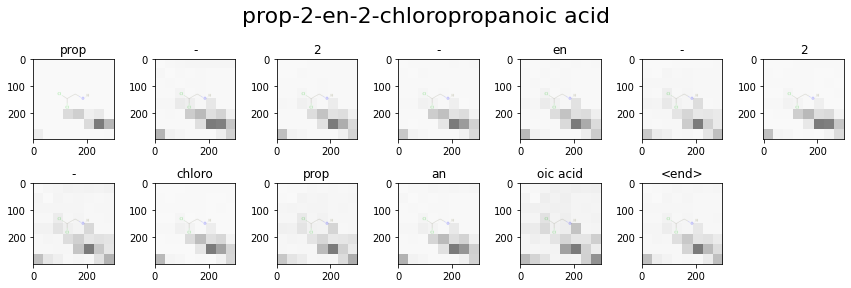

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_train[55], max_length_test)

print ('Real Caption:', caption_train[55])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_train[55], result, attention_plot)

# WER, MER, WIL, WIP

- WER = Word Error Rate
- MER = Match Error Rate
- WIL = Word Information Lost
- WIP = Word Information Preserved

In [ ]:
!pip install jiwer

In [ ]:
import jiwer

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=False),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
]) 

In [ ]:
ground_truth, _ = kme_segment.word_segmentation(caption_test[118])
hypothesis, _ = evaluate(image_test[118], max_length_test)
score = jiwer.compute_measures(
    ground_truth,
    hypothesis[:-1], 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

print(ground_truth)
print(hypothesis[:-1])
print(score)

['2', ',', '2', ',', '3', ',', '3', ',', '4', ',', '4', ',', '4', '-', 'hepta', 'fluoro', 'but', 'an', 'oic acid']
['1', ',', '3', ',', '3', ',', '4', ',', '4', '-', 'tri', 'meth', 'yl', 'hex', 'ane']
{'wer': 0.5263157894736842, 'mer': 0.5263157894736842, 'wil': 0.7157894736842105, 'wip': 0.28421052631578947, 'hits': 9, 'substitutions': 6, 'deletions': 4, 'insertions': 0}


# BLEU SCORE

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## All Bleu Score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nami.AI.kme_tokenize import Segmentation
from tqdm.notebook import trange
kme_segment = Segmentation()
score1, score2, score3, score4 = [], [], [], []
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)

  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score1 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(1.0, 0, 0, 0), smoothing_function = chencherry.method4)]))
  score2 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.5, 0.5, 0, 0), smoothing_function = chencherry.method4)]))
  score3 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.3, 0.3, 0.3, 0), smoothing_function = chencherry.method4)]))
  score4 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function = chencherry.method4)]))

In [ ]:
print(f"BLEU1 {np.mean(score1)*100}\n"
      f"BLEU2 {np.mean(score2)*100}\n"
      f"BLEU3 {np.mean(score3)*100}\n"
      f"BLEU4 {np.mean(score4)*100}\n"
      )

BLEU1 30.104544997795816
BLEU2 29.991428209183695
BLEU3 29.975430691215116
BLEU4 24.43828088270166



In [ ]:
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_train)):
  word_arr, _ = evaluate(image_train[i], max_length_train)
  real_word,_ = kme_segment.word_segmentation(caption_train[i])

  score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
  best_score[i] = score
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_train[i])

In [ ]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

In [ ]:
for i in range(30):
  print(sort_best_score[i][0], sort_best_score[i][1])

33 1.0
114 1.0
212 1.0
316 1.0
323 1.0
367 1.0
385 1.0
452 1.0
542 1.0
569 1.0
282 0.9193227152249185
175 0.8931539818068694
540 0.8408964152537145
13 0.8091067115702212
563 0.8091067115702212
336 0.7598356856515925
369 0.7419446627365011
204 0.7259795291154771
287 0.7071067811865475
66 0.7016879391277372
227 0.7016879391277372
292 0.6989307622784944
604 0.6736041912625804
419 0.668740304976422
17 0.6606328636027614
135 0.6606328636027614
378 0.6262844962765469
565 0.6223329772884784
216 0.6186101569833722
163 0.6147881529512643


# Example

Real Caption: 3-methylbutanoic acid
Prediction Caption: 2-methylbutanoic acid


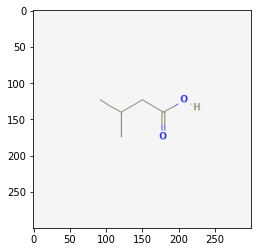

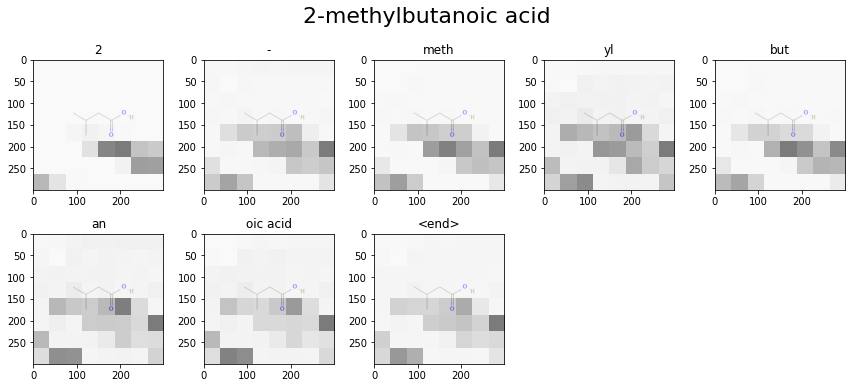

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_train[13], max_length_train)

print ('Real Caption:', caption_train[13])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_train[13])
plt.show()
plot_attention(image_train[13], result, attention_plot)


Real Caption: deca-1,6-diyne
Prediction Caption: deca-1,6-diyne


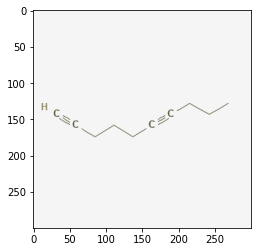

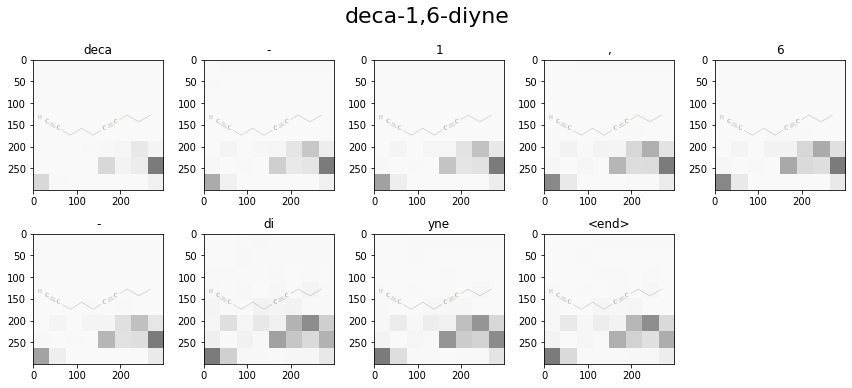

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[52], max_length_test)

print ('Real Caption:', caption_test[52])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[52])
plt.show()
plot_attention(image_test[52], result, attention_plot)


Real Caption: prop-2-en-1-ol
Prediction Caption: prop-2-en-1-ol


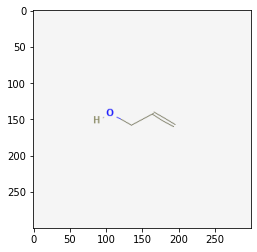

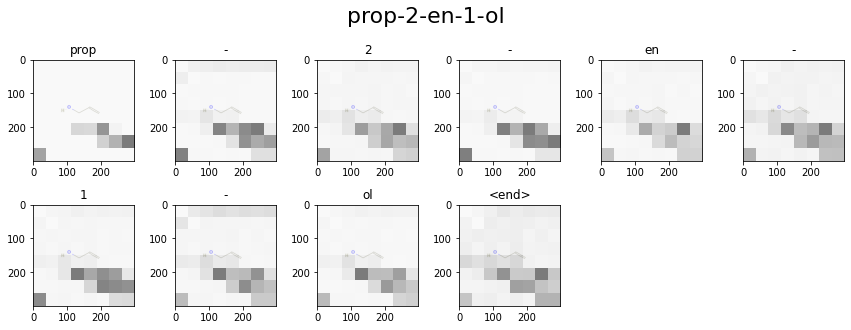

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[243], max_length_train)

print ('Real Caption:', caption_test[243])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[243])
plt.show()
plot_attention(image_test[243], result, attention_plot)


Real Caption: 1,1-bis(methylsulfanyl)ethene
Prediction Caption: 1,3-dimethylpropane


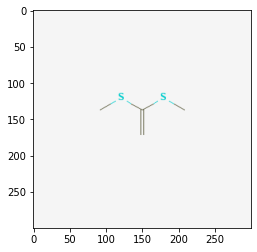

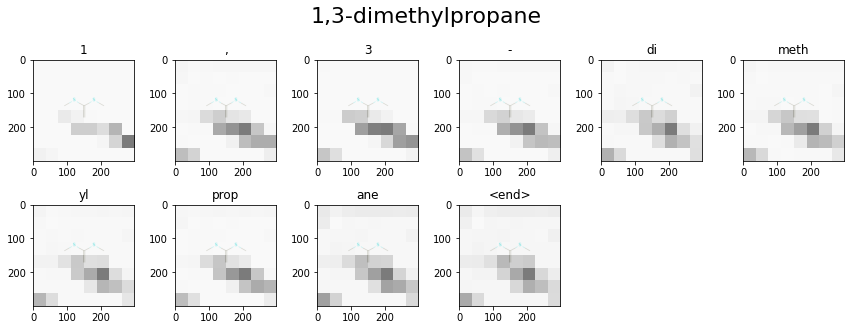

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[22], max_length_test)

print ('Real Caption:', caption_test[22])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[22])
plt.show()
plot_attention(image_test[22], result, attention_plot)
